In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from energyquantified import EnergyQuantified
from energyquantified.metadata import ContractPeriod
from statsmodels.tsa.seasonal import seasonal_decompose

from historicl_movement_functions.ttf_download_hisotry import ttf_download_hisotry_func
from datetime import datetime

In [2]:


download_date = datetime(2006, 1, 1).date()
dataframes = ttf_download_hisotry_func(download_date)

df = dataframes['df_TTF_MONTH']
df = df.ffill()
df['traded'] = pd.to_datetime(df['traded'])

# Sort the DataFrame to ensure correct date order
df.sort_values(by='traded', inplace=True)
df['settlement_pct_change'] = df['settlement'].pct_change() * 100
df = df[df['traded'] <= datetime(2021, 1, 1)]
print(df)


2025-09-17 13:07:01.134 
  command:

    streamlit run ipykernel_launcher [ARGUMENTS]
         traded period  front    delivery   open   high    low  close  \
0    2006-01-02  month      1  2006-02-01    NaN    NaN    NaN    NaN   
1    2006-01-03  month      1  2006-02-01    NaN    NaN    NaN    NaN   
2    2006-01-04  month      1  2006-02-01    NaN    NaN    NaN    NaN   
3    2006-01-05  month      1  2006-02-01    NaN    NaN    NaN    NaN   
4    2006-01-06  month      1  2006-02-01    NaN    NaN    NaN    NaN   
...         ...    ...    ...         ...    ...    ...    ...    ...   
3746 2020-12-23  month      1  2021-01-01  17.80  18.25  17.09  17.40   
3747 2020-12-24  month      1  2021-01-01  17.45  17.80  17.00  17.77   
3748 2020-12-28  month      1  2021-01-01  18.27  19.43  18.27  18.95   
3749 2020-12-29  month      1  2021-01-01  19.10  19.12  18.46  18.86   
3750 2020-12-30  month      1  2021-01-01  18.81  19.55  18.78  18.89   

      settlement   volume  open_inter

C:\Users\svecd2\AppData\Local\Temp\ipykernel_21996\1575246467.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('traded')['settlement'].resample('M').mean()


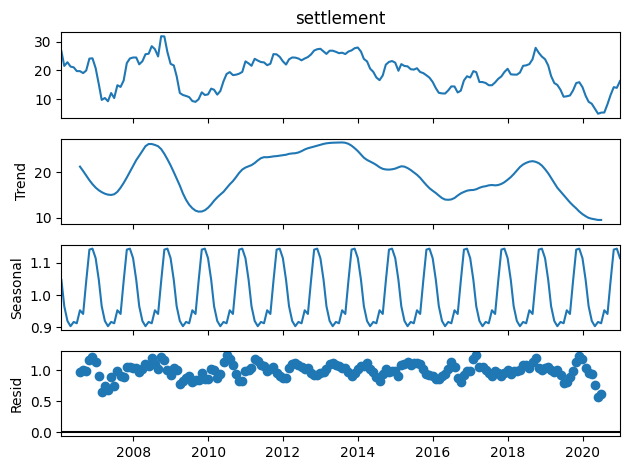

In [3]:
# Make a monthly average settlement series
monthly = df.set_index('traded')['settlement'].resample('M').mean()
# Decompose with a 12-month seasonal cycle
result = seasonal_decompose(monthly.dropna(), model='multiplicative', period=12)

# Plot the decomposition
result.plot()
plt.show()

# Extract the seasonal component (normalized around 1.0 for multiplicative model)
seasonal_factor = result.seasonal

In [4]:
seasonal_factor

traded
2006-01-31    1.046535
2006-02-28    0.965386
2006-03-31    0.919729
2006-04-30    0.903594
2006-05-31    0.916764
                ...   
2020-08-31    0.941450
2020-09-30    1.042956
2020-10-31    1.140585
2020-11-30    1.143534
2020-12-31    1.114069
Freq: ME, Name: seasonal, Length: 180, dtype: float64

In [5]:
monthly_profile = seasonal_factor.groupby(seasonal_factor.index.month).mean()

# Normalize the 12-month profile so the average factor is 1.0 
monthly_profile = monthly_profile / monthly_profile.mean()
monthly_profile

traded
1     1.046535
2     0.965386
3     0.919729
4     0.903594
5     0.916764
6     0.912571
7     0.952825
8     0.941450
9     1.042956
10    1.140585
11    1.143534
12    1.114069
Name: seasonal, dtype: float64

In [6]:
api_key = 'ebbdc4-a81661-5dfb18-e24b2e'
http_proxy  = "http://proxy.spp.sk:8080"
https_proxy  = "http://proxy.spp.sk:8080"

proxies = {"http"  : http_proxy,
            "https"  : https_proxy}

eq = EnergyQuantified(api_key=api_key, proxies= proxies)
eq.is_api_key_valid()

today = date.today()
ohlc = eq.ohlc.latest(
   'NL Futures Natural Gas EUR/MWh ICE-TTF OHLC',
   date=today
)

In [7]:
forward_prices = ohlc.to_dataframe()
forward_prices


,traded,period,front,delivery,open,high,low,close,settlement,volume,open_interest
0,2025-09-16,day,1,2025-09-17,NaN,NaN,NaN,NaN,31.85,0.0,470.0
1,2025-09-16,day,2,2025-09-18,NaN,NaN,NaN,NaN,31.95,0.0,470.0
2,2025-09-16,day,3,2025-09-19,NaN,NaN,NaN,NaN,31.95,0.0,470.0
3,2025-09-16,month,1,2025-10-01,32.0,32.48,31.62,32.42,32.33,78251.0,167895.0
4,2025-09-16,month,2,2025-11-01,32.9,33.21,32.40,33.13,33.06,33083.0,153621.0
...,...,...,...,...,...,...,...,...,...,...,...
94,2025-09-16,year,4,2029-01-01,24.9,24.90,24.90,24.90,24.85,5.0,NaN
95,2025-09-16,year,5,2030-01-01,24.2,24.20,24.20,24.20,24.27,35.0,NaN
96,2025-09-16,year,6,2031-01-01,NaN,NaN,NaN,NaN,24.18,0.0,NaN
97,2025-09-16,year,7,2032-01-01,NaN,NaN,NaN,NaN,24.48,0.0,NaN


In [8]:
forward_prices = forward_prices.loc[forward_prices['period'].eq('month')].copy()

# 2) ensure delivery is datetime
forward_prices['delivery'] = pd.to_datetime(forward_prices['delivery'], errors='coerce')

# 3) add year and month columns
forward_prices['year'] = forward_prices['delivery'].dt.year
forward_prices['month'] = forward_prices['delivery'].dt.month_name()   # use .dt.month_name() for names instead or dt.month 


In [9]:
forward_prices

,traded,period,front,delivery,open,high,low,close,settlement,volume,open_interest,year,month
3,2025-09-16,month,1,2025-10-01,32.00,32.48,31.62,32.42,32.33,78251.0,167895.0,2025,October
4,2025-09-16,month,2,2025-11-01,32.90,33.21,32.40,33.13,33.06,33083.0,153621.0,2025,November
5,2025-09-16,month,3,2025-12-01,33.39,33.68,32.93,33.65,33.58,16569.0,147676.0,2025,December
6,2025-09-16,month,4,2026-01-01,33.49,33.90,33.15,33.83,33.80,15168.0,132370.0,2026,January
7,2025-09-16,month,5,2026-02-01,33.39,33.86,33.15,33.84,33.80,10390.0,125269.0,2026,February
8,2025-09-16,month,6,2026-03-01,33.06,33.31,32.62,33.30,33.24,12065.0,145232.0,2026,March
9,2025-09-16,month,7,2026-04-01,31.71,31.91,31.32,31.87,31.85,9460.0,93374.0,2026,April
10,2025-09-16,month,8,2026-05-01,31.14,31.34,30.85,31.34,31.36,7159.0,67467.0,2026,May
11,2025-09-16,month,9,2026-06-01,30.80,31.28,30.80,31.25,31.29,6569.0,68348.0,2026,June
12,2025-09-16,month,10,2026-07-01,30.84,31.02,30.84,31.02,31.33,4648.0,69986.0,2026,July


In [10]:
today = pd.Timestamp.today().normalize()
cutoff_year = today.year if today.month <= 4 else today.year + 2
cutoff = pd.Timestamp(cutoff_year, 4, 30)

forward_prices = (
    forward_prices
      .loc[forward_prices['period'].eq('month') & (forward_prices['delivery'] <= cutoff)]
      .sort_values('delivery')['settlement']
      .to_numpy(dtype=float)
)


In [11]:
forward_prices

array([32.33, 33.06, 33.58, 33.8 , 33.8 , 33.24, 31.85, 31.36, 31.29,
       31.33, 31.41, 31.61, 31.78, 32.5 , 32.88, 33.  , 32.86, 32.17,
       29.21])

In [12]:
min_inventory = 0       # minimum inventory (e.g. 0 units)
max_inventory = 500000   # maximum inventory (e.g. 1000 units)

start_inventory = 400000   # starting inventory level (e.g. 500 units)

injection_percentage_ratchet = [0, 30, 80, 100]
injection_volume_ratchet = [6370, 5096, 3822, 0]

withdraw_percentage_ratchet = [0, 25, 100]
withdraw_volume_ratchet = [4430, 8860, 8860]



In [13]:
from monte_carlo_simulation import monte_carlo_simulation_func

best_df, best_profit = monte_carlo_simulation_func(min_inventory, max_inventory, forward_prices,start_inventory, injection_percentage_ratchet,injection_volume_ratchet, withdraw_percentage_ratchet, withdraw_volume_ratchet, monthly_profile, n_sims=10000, daily_volatility=0.4)


In [14]:

print(best_df.head(10)) 

         Date  Forward Price    Action  Volume  End Inventory
0  2025-09-01         33.719      Hold     0.0       400000.0
1  2025-09-02         33.811      Hold     0.0       400000.0
2  2025-09-03         33.805      Hold     0.0       400000.0
3  2025-09-04         33.604  Withdraw  8860.0       391140.0
4  2025-09-05         33.636      Hold     0.0       391140.0
5  2025-09-06         33.687  Withdraw  8860.0       382280.0
6  2025-09-07         33.657    Inject  5096.0       387376.0
7  2025-09-08         33.774      Hold     0.0       387376.0
8  2025-09-09         33.743      Hold     0.0       387376.0
9  2025-09-10         33.775  Withdraw  8860.0       378516.0


Best scenario intrinsic value (profit): EUR 14020679.39


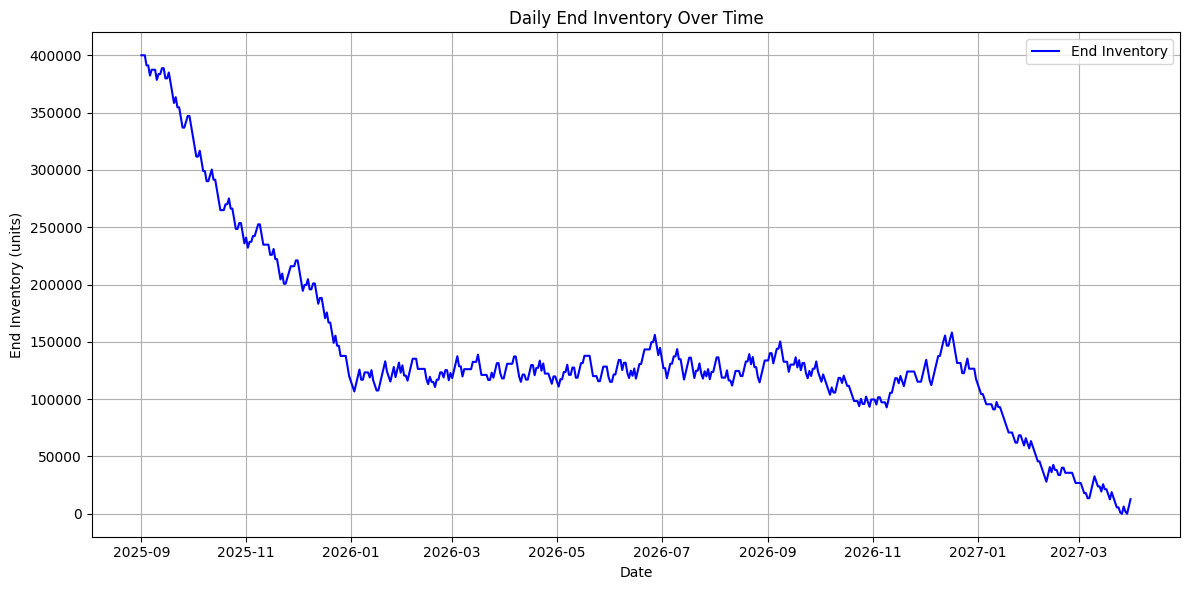

In [15]:
print("Best scenario intrinsic value (profit): EUR", round(best_profit, 2))
plt.figure(figsize=(12,6))
plt.plot(best_df["Date"], best_df["End Inventory"], label="End Inventory", color="blue")
plt.xlabel("Date")
plt.ylabel("End Inventory (units)")
plt.title("Daily End Inventory Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
from monte_carlo_storage_lsmc import monte_carlo_storage_lsmc_func

min_inv = 0
max_inv = 500000
start_inv = 400000
inj_pct = [0, 30, 80, 100]
inj_vol = [6370, 5096, 3822, 0]
wd_pct  = [0, 25, 100]
wd_vol  = [4430, 8860, 8860]

value0, schedule_df, dates, policy = monte_carlo_storage_lsmc_func(
    forward_prices, monthly_profile,
    min_inv, max_inv, start_inv,
    inj_pct, inj_vol, wd_pct, wd_vol,
    n_sims=5000, daily_volatility=0.4, kappa=3.0,
    annual_inflation=0.02, r_annual=0.03, seed=42
)

print("LSMC expected NPV:", round(value0, 2))
print(schedule_df.head())

LSMC expected NPV: 19929793.9
         Date  Forward Price  Action  Volume  End Inventory
0  2025-09-01         33.719    Hold     0.0       400000.0
1  2025-09-02         33.711    Hold     0.0       400000.0
2  2025-09-03         33.711    Hold     0.0       400000.0
3  2025-09-04         33.721  Inject  3822.0       403822.0
4  2025-09-05         33.664  Inject  3822.0       407644.0


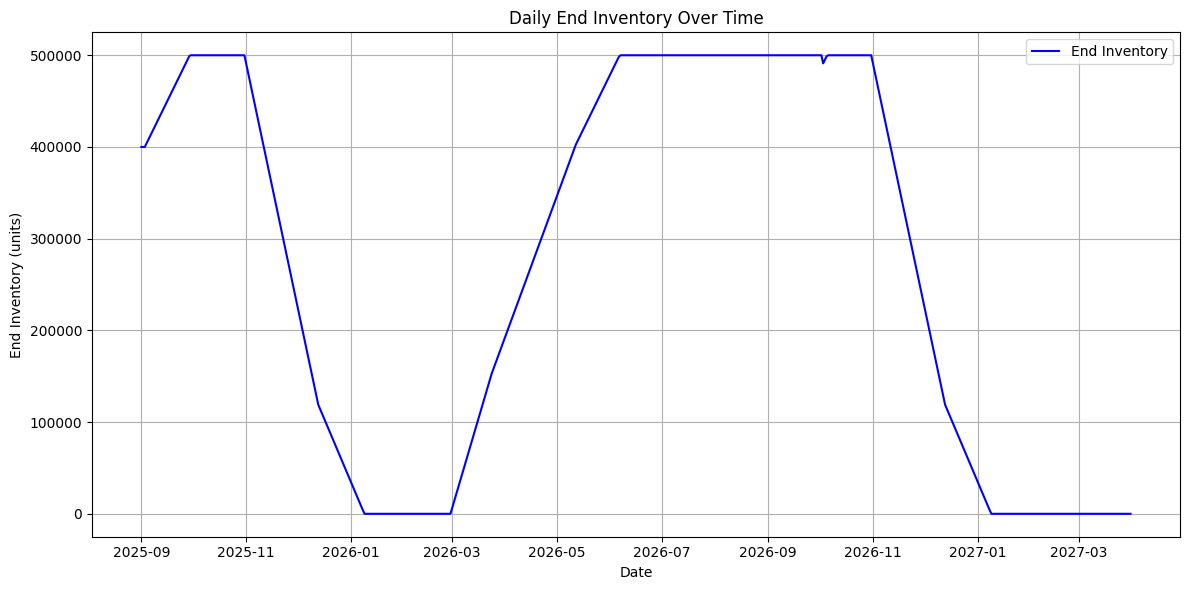

In [26]:

plt.figure(figsize=(12,6))
plt.plot(schedule_df["Date"], schedule_df["End Inventory"], label="End Inventory", color="blue")
plt.xlabel("Date")
plt.ylabel("End Inventory (units)")
plt.title("Daily End Inventory Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()